In [653]:
#importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [654]:
df= pd.read_csv('London.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418201 entries, 0 to 418200
Data columns (total 28 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   fullAddress                                418201 non-null  object 
 1   postcode                                   418201 non-null  object 
 2   country                                    418201 non-null  object 
 3   outcode                                    418201 non-null  object 
 4   latitude                                   418201 non-null  float64
 5   longitude                                  418201 non-null  float64
 6   bathrooms                                  340270 non-null  float64
 7   bedrooms                                   377665 non-null  float64
 8   floorAreaSqM                               392991 non-null  float64
 9   livingRooms                                357701 non-null  float64
 10  tenure  

In [655]:
df.columns

Index(['fullAddress', 'postcode', 'country', 'outcode', 'latitude',
       'longitude', 'bathrooms', 'bedrooms', 'floorAreaSqM', 'livingRooms',
       'tenure', 'propertyType', 'currentEnergyRating',
       'rentEstimate_lowerPrice', 'rentEstimate_currentPrice',
       'rentEstimate_upperPrice', 'saleEstimate_lowerPrice',
       'saleEstimate_currentPrice', 'saleEstimate_upperPrice',
       'saleEstimate_confidenceLevel', 'saleEstimate_ingestedAt',
       'saleEstimate_valueChange.numericChange',
       'saleEstimate_valueChange.percentageChange',
       'saleEstimate_valueChange.saleDate', 'history_date', 'history_price',
       'history_percentageChange', 'history_numericChange'],
      dtype='object')

In [656]:
df.isnull().sum()

fullAddress                                       0
postcode                                          0
country                                           0
outcode                                           0
latitude                                          0
longitude                                         0
bathrooms                                     77931
bedrooms                                      40536
floorAreaSqM                                  25210
livingRooms                                   60500
tenure                                        11512
propertyType                                   1136
currentEnergyRating                           84526
rentEstimate_lowerPrice                        1741
rentEstimate_currentPrice                      1741
rentEstimate_upperPrice                        1741
saleEstimate_lowerPrice                         640
saleEstimate_currentPrice                       640
saleEstimate_upperPrice                         640
saleEstimate

In [657]:
# Drop rows where the target (current sale price) is missing
df = df.dropna(subset=['saleEstimate_currentPrice'])

In [658]:
# Impute numeric columns with median
numeric_cols = ['bathrooms', 'bedrooms', 'floorAreaSqM']
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Drop very sparse or non-essential columns
# Check if columns exist before dropping them
columns_to_drop = ['livingRooms', 'currentEnergyRating']
existing_columns = [col for col in columns_to_drop if col in df.columns]
if existing_columns:
    df = df.drop(columns=existing_columns)

# Impute categorical with most frequent value
df['tenure'] = df['tenure'].fillna(df['tenure'].mode()[0])
df['propertyType'] = df['propertyType'].fillna(df['propertyType'].mode()[0])

In [659]:
# Check again
print(df.isnull().sum().sort_values(ascending=False).head(10))

history_percentageChange     179928
history_numericChange        179928
rentEstimate_currentPrice      1101
rentEstimate_lowerPrice        1101
rentEstimate_upperPrice        1101
latitude                          0
country                           0
outcode                           0
fullAddress                       0
postcode                          0
dtype: int64


In [660]:
# Drop columns with excessive missing values and irrelevant to sale price prediction
df = df.drop(columns=[
    'history_percentageChange',
    'history_numericChange',
    'rentEstimate_currentPrice',
    'rentEstimate_lowerPrice',
    'rentEstimate_upperPrice'
])

In [661]:
# Check again
print(df.isnull().sum().sort_values(ascending=False).head(10))

fullAddress     0
postcode        0
country         0
outcode         0
latitude        0
longitude       0
bathrooms       0
bedrooms        0
floorAreaSqM    0
tenure          0
dtype: int64


In [662]:
# Identify and Handle Outliers (for numerical columns)
# Remove rows where current price is extremely high or low
q1 = df['saleEstimate_currentPrice'].quantile(0.01)
q3 = df['saleEstimate_currentPrice'].quantile(0.99)
london_data = df[(df['saleEstimate_currentPrice'] >= q1) &
                          (df['saleEstimate_currentPrice'] <= q3)]

In [663]:
# Drop rows where target is missing
df = df.dropna(subset=['saleEstimate_currentPrice'])

# Optionally: Drop rows where latitude or longitude is missing (they're critical)
df = df.dropna(subset=['latitude', 'longitude'])

# Show how many are left
print(f"Dataset shape after dropping critical nulls: {df.shape}")

Dataset shape after dropping critical nulls: (417561, 21)


In [664]:
df = pd.get_dummies(london_data, columns=['tenure', 'propertyType'], drop_first=True)

In [665]:
print("\nData after One-Hot Encoding:")
print(df.head())
print("New number of columns:", df.shape[1])


Data after One-Hot Encoding:
                                         fullAddress  postcode  country  \
0       Flat 9, 35 Furnival Street, London, EC4A 1JQ  EC4A 1JQ  England   
1       Flat 6, 35 Furnival Street, London, EC4A 1JQ  EC4A 1JQ  England   
2  Flat 35, Octavia House, Medway Street, London,...  SW1P 2TA  England   
3    24 Chester Court, Lomond Grove, London, SE5 7HS   SE5 7HS  England   
4              18 Alexandra Gardens, London, N10 3RL   N10 3RL  England   

  outcode   latitude  longitude  bathrooms  bedrooms  floorAreaSqM  \
0    EC4A  51.517282  -0.110314        1.0       1.0          45.0   
1    EC4A  51.517282  -0.110314        1.0       2.0          84.0   
2    SW1P  51.495505  -0.132379        2.0       2.0          71.0   
3     SE5  51.478185  -0.092201        1.0       1.0          64.0   
4     N10  51.588774  -0.139599        1.0       4.0         137.0   

   saleEstimate_lowerPrice  ...  propertyType_Mid Terrace Bungalow  \
0                 570000.0  

In [666]:
# Import the StandardScaler from sklearn
from sklearn.preprocessing import StandardScaler
import numpy as np

# Step 5: Feature Scaling (for numerical columns, after encoding if new numerical columns were created)
print("\n--- Feature Scaling ---")
# Scaling numerical features is important for many regression algorithms, especially if features have different scales.
# This helps prevent features with larger values from dominating the model.

# Re-identify numerical columns after one-hot encoding
numerical_cols_after_encoding = df.select_dtypes(include=np.number).columns

scaler = StandardScaler()
df[numerical_cols_after_encoding] = scaler.fit_transform(df[numerical_cols_after_encoding])

print("\nData after Feature Scaling (first 5 rows of scaled numerical columns):")
print(df[numerical_cols_after_encoding].head())

# Step 6: Verify Data Types and Final Check
print("\n--- Final Data Check ---")
print("\nData types after cleaning:")
print(df.dtypes)
print("\nFinal shape of the cleaned data:", df.shape)
print("\nCleaned Data (first 5 rows):")
print(df.head())


--- Feature Scaling ---

Data after Feature Scaling (first 5 rows of scaled numerical columns):
   latitude  longitude  bathrooms  bedrooms  floorAreaSqM  \
0  0.173265  -0.101967  -0.547358 -1.305030     -1.025017   
1  0.173265  -0.101967  -0.547358 -0.385977     -0.252089   
2 -0.214038  -0.356709   1.025030 -0.385977     -0.509732   
3 -0.522052   0.107151  -0.547358 -1.305030     -0.648463   
4  1.444703  -0.440068  -0.547358  1.452129      0.798299   

   saleEstimate_lowerPrice  saleEstimate_currentPrice  \
0                -0.352467                  -0.369930   
1                -0.401080                  -0.369930   
2                -0.169358                  -0.137357   
3                -0.679795                  -0.680028   
4                 0.665165                   0.596932   

   saleEstimate_upperPrice  saleEstimate_valueChange.numericChange  \
0                -0.381822                                0.212667   
1                -0.342089                           

In [667]:
# Step 6: Verify Data Types and Final Check
print("\n--- Final Data Check ---")
print("\nData types after cleaning:")
print(df.dtypes)
print("\nFinal shape of the cleaned data:", df.shape)
print("\nCleaned Data (first 5 rows):")
print(df.head())


--- Final Data Check ---

Data types after cleaning:
fullAddress                                   object
postcode                                      object
country                                       object
outcode                                       object
latitude                                     float64
longitude                                    float64
bathrooms                                    float64
bedrooms                                     float64
floorAreaSqM                                 float64
saleEstimate_lowerPrice                      float64
saleEstimate_currentPrice                    float64
saleEstimate_upperPrice                      float64
saleEstimate_confidenceLevel                  object
saleEstimate_ingestedAt                       object
saleEstimate_valueChange.numericChange       float64
saleEstimate_valueChange.percentageChange    float64
saleEstimate_valueChange.saleDate             object
history_date                                 

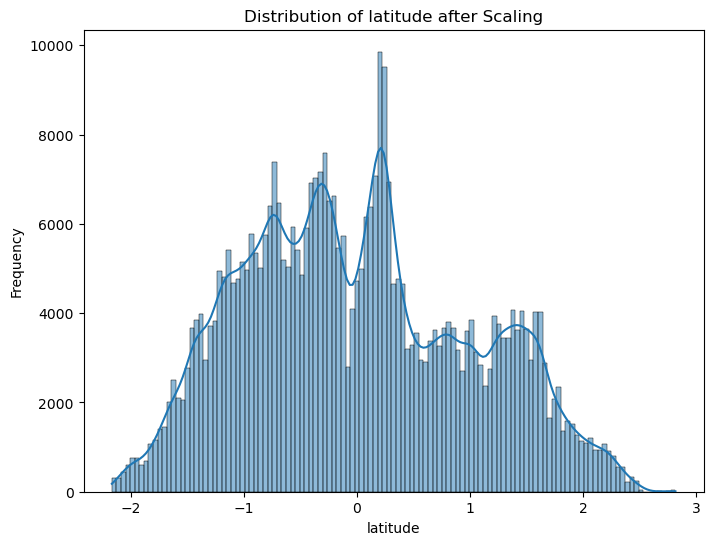

In [668]:
if not numerical_cols_after_encoding.empty:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[numerical_cols_after_encoding[0]], kde=True)
    plt.title(f'Distribution of {numerical_cols_after_encoding[0]} after Scaling')
    plt.xlabel(numerical_cols_after_encoding[0])
    plt.ylabel('Frequency')
    plt.show()

In [669]:
numeric_cols = london_data.select_dtypes(include=['float64', 'int64']).columns
print("Numeric Columns:", numeric_cols)

Numeric Columns: Index(['latitude', 'longitude', 'bathrooms', 'bedrooms', 'floorAreaSqM',
       'saleEstimate_lowerPrice', 'saleEstimate_currentPrice',
       'saleEstimate_upperPrice', 'saleEstimate_valueChange.numericChange',
       'saleEstimate_valueChange.percentageChange', 'history_price'],
      dtype='object')


In [670]:
def remove_outliers_all_numeric(df):
    """
    Remove outliers from all numeric columns using IQR method.
    """
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df
# Apply the function
london_data_clean = remove_outliers_all_numeric(london_data)

print("Original Shape:", london_data.shape)
print("After Removing Outliers:", london_data_clean.shape)

Original Shape: (409246, 21)
After Removing Outliers: (264766, 21)


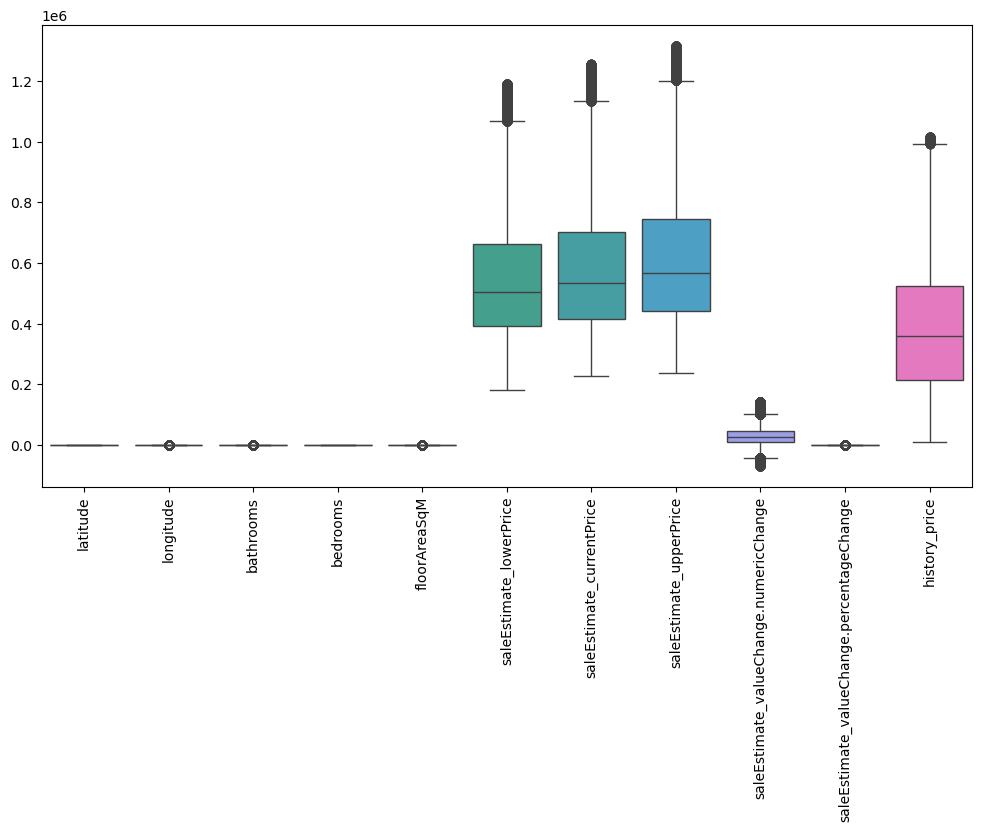

In [671]:
#show boxplot again
plt.figure(figsize=(12,6))
sns.boxplot(data=london_data_clean[numeric_cols])
plt.xticks(rotation=90)
plt.show()

In [672]:
#Capping out extreme prices of saleEstimate_currentPrice
def cap_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    return df

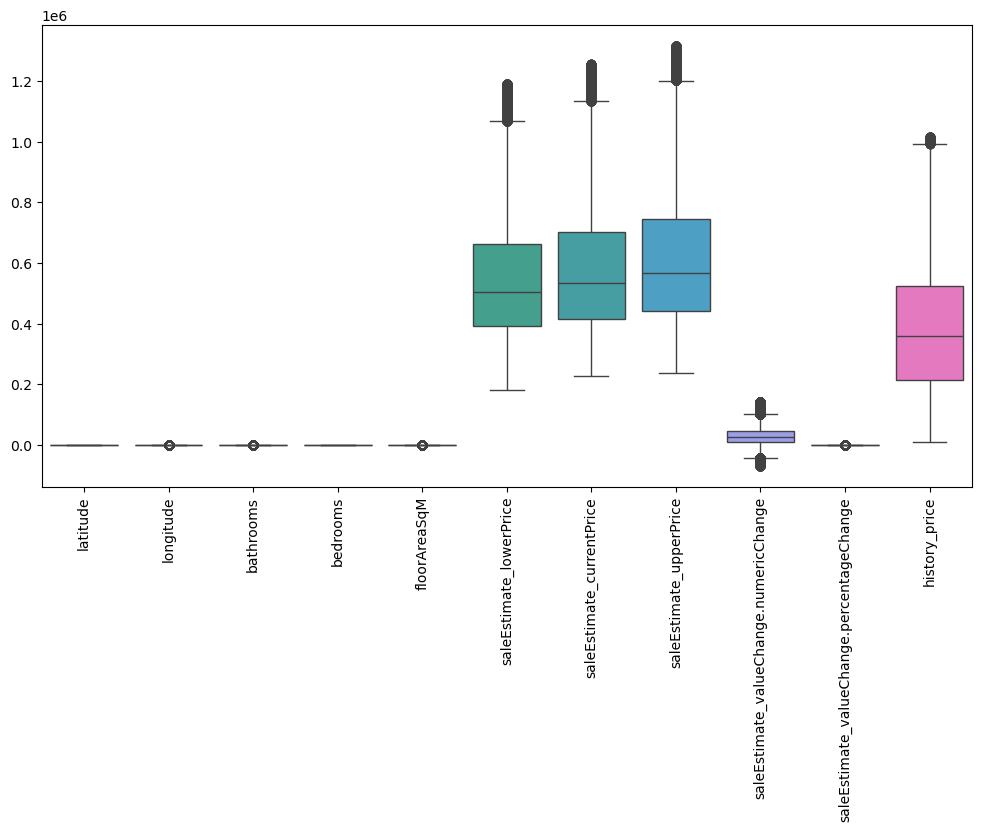

In [673]:
#show boxplot again
plt.figure(figsize=(12,6))
sns.boxplot(data=london_data_clean[numeric_cols])
plt.xticks(rotation=90)
plt.show()

In [674]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [675]:
#Define features and target
features = ['bathrooms', 'bedrooms', 'floorAreaSqM', 
            'latitude', 'longitude', 
            'saleEstimate_valueChange.numericChange']
target = 'saleEstimate_currentPrice'
x = df[features]
y = df[target]

In [676]:
df.shape

(409246, 40)

In [677]:
#scaling features
#scaling features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(x), columns=features)  # Changed pd.df to pd.DataFrame

In [678]:
#Split Data 
x_train, x_test, y_train, y_test = train_test_split(x,y ,test_size = 0.2, random_state = 42)

In [679]:
#Train model
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [680]:
#make predictions
y_pred = model.predict(x_test)

In [681]:
#checking model performance
#checking model performance
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)  # Remove the squared parameter
mse = np.sqrt(mse)  # Calculate RMSE by taking the square root of MSE
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {mse:.2f}")

R² Score: 0.5588
RMSE: 0.67


In [682]:
# Add price per square meter
df['price_per_sqm'] = df['saleEstimate_currentPrice'] / df['floorAreaSqM']
# Add bedroom-to-bathroom ratio (avoid division by zero)
df['bed_bath_ratio'] = np.where(london_data['bathrooms'] == 0, 
                                         london_data['bedrooms'], 
                                         london_data['bedrooms'] / london_data['bathrooms'])
# Include useful price trend features
extra_features = ['saleEstimate_lowerPrice', 'saleEstimate_upperPrice',
                  'saleEstimate_valueChange.percentageChange', 'history_price']
# Combine everything
features = ['bathrooms', 'bedrooms', 'floorAreaSqM', 'latitude', 'longitude', 
            'saleEstimate_valueChange.numericChange', 'price_per_sqm', 'bed_bath_ratio'] + extra_features
x = df[features]
y = df['saleEstimate_currentPrice']

In [683]:
scaler = StandardScaler()
x_scaled = pd.DataFrame(scaler.fit_transform(x), columns=features)

In [684]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

In [685]:
#Linear Regression
lin_model = LinearRegression()
lin_model.fit(x_train, y_train)
y_pred_lin = lin_model.predict(x_test)
r2_lin = r2_score(y_test, y_pred_lin)
mse_lin = mean_squared_error(y_test, y_pred_lin)  # Calculate MSE without the squared parameter
rmse_lin = np.sqrt(mse_lin)  # Take the square root of MSE to get RMSE
print(r2_lin)
print(mse_lin)
print(rmse_lin) 

0.999999733415869
2.6929889536363354e-07
0.0005189401654946682


In [686]:
# Ridge Regression
# Ridge Regression
# Import the Ridge class from sklearn.linear_model
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(x_train, y_train)
y_pred_ridge = ridge_model.predict(x_test)
r2_ridge = r2_score(y_test, y_pred_ridge)

# Calculate RMSE manually instead of using the squared parameter
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)  # Take square root of MSE to get RMSE

In [687]:
# Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(x_train, y_train)

Ridge()

In [688]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np  # Import numpy for calculating square root

# Lasso Regression
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(x_train, y_train)
y_pred_lasso = lasso_model.predict(x_test)
r2_lasso = r2_score(y_test, y_pred_lasso)

# Calculate RMSE manually by taking the square root of MSE
# This works with all versions of scikit-learn
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

In [689]:
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(x_train, y_train)

Lasso(alpha=0.1)

In [690]:
# LINEAR REGRESSION EQUATION 
feature_names = ['latitude', 'longitude', 'bathrooms', 'bedrooms', 'floorAreaSqM',
                 'saleEstimate_valueChange.numericChange', 'saleEstimate_valueChange.percentageChange',
                 'history_price', 'price_per_sqm', 'bed_bath_ratio']

coefficients = lin_model.coef_
intercept = lin_model.intercept_
# Display the equation
print("Linear Regression Equation:")
equation = f"saleEstimate_currentPrice = {intercept:.2f} "
for feature, coef in zip(feature_names, coefficients):
    equation += f"+ ({coef:.2f} * {feature}) "
print(equation)

Linear Regression Equation:
saleEstimate_currentPrice = -0.00 + (-0.00 * latitude) + (0.00 * longitude) + (0.00 * bathrooms) + (-0.00 * bedrooms) + (-0.00 * floorAreaSqM) + (-0.00 * saleEstimate_valueChange.numericChange) + (-0.00 * saleEstimate_valueChange.percentageChange) + (-0.00 * history_price) + (0.45 * price_per_sqm) + (0.55 * bed_bath_ratio) 


In [691]:
x_unscaled = pd.DataFrame(scaler.inverse_transform(x_scaled), columns=features)

In [692]:
#re-train the Linear Regression model without feature scaling for actual price 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
# Use safe features (same as before)
features = [
    'latitude', 'longitude', 'bathrooms', 'bedrooms', 'floorAreaSqM',
    'saleEstimate_valueChange.numericChange', 'saleEstimate_valueChange.percentageChange',
    'history_price', 'price_per_sqm', 'bed_bath_ratio'
]

In [693]:
x = df[features]
y = df['saleEstimate_currentPrice']

In [694]:
# Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [695]:
# Train Linear Regression
lin_model_no_scale = LinearRegression().fit(x_train, y_train)

In [696]:
#FINAL LINEAR REGRESSION MODEL
coefficients = lin_model_no_scale.coef_
intercept = lin_model_no_scale.intercept_
print("Linear Regression Equation (No Scaling):")
equation = f"saleEstimate_currentPrice = {intercept:.2f} "
for feature, coef in zip(features, coefficients):
    equation += f"+ ({coef:.2f} * {feature}) "
print(equation)

Linear Regression Equation (No Scaling):
saleEstimate_currentPrice = -0.25 + (0.00 * latitude) + (-0.15 * longitude) + (0.22 * bathrooms) + (-0.19 * bedrooms) + (0.49 * floorAreaSqM) + (0.41 * saleEstimate_valueChange.numericChange) + (0.02 * saleEstimate_valueChange.percentageChange) + (0.59 * history_price) + (0.00 * price_per_sqm) + (0.13 * bed_bath_ratio) 


In [697]:
print("Model with New Features:")
print(f"Linear  -> R²: {r2_lin:.4f}, RMSE: {rmse_lin:.2f}")
print(f"Ridge   -> R²: {r2_ridge:.4f}, RMSE: {rmse_ridge:.2f}")
print(f"Lasso   -> R²: {r2_lasso:.4f}, RMSE: {rmse_lasso:.2f}")

Model with New Features:
Linear  -> R²: 1.0000, RMSE: 0.00
Ridge   -> R²: 1.0000, RMSE: 0.00
Lasso   -> R²: 0.9899, RMSE: 0.10


Load Miami Dataset

In [698]:
df1= pd.read_csv('miami-housing.csv')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13932 entries, 0 to 13931
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   LATITUDE           13932 non-null  float64
 1   LONGITUDE          13932 non-null  float64
 2   PARCELNO           13932 non-null  int64  
 3   SALE_PRC           13932 non-null  float64
 4   LND_SQFOOT         13932 non-null  int64  
 5   TOT_LVG_AREA       13932 non-null  int64  
 6   SPEC_FEAT_VAL      13932 non-null  int64  
 7   RAIL_DIST          13932 non-null  float64
 8   OCEAN_DIST         13932 non-null  float64
 9   WATER_DIST         13932 non-null  float64
 10  CNTR_DIST          13932 non-null  float64
 11  SUBCNTR_DI         13932 non-null  float64
 12  HWY_DIST           13932 non-null  float64
 13  age                13932 non-null  int64  
 14  avno60plus         13932 non-null  int64  
 15  month_sold         13932 non-null  int64  
 16  structure_quality  139

In [699]:
df1.isnull().sum()

LATITUDE             0
LONGITUDE            0
PARCELNO             0
SALE_PRC             0
LND_SQFOOT           0
TOT_LVG_AREA         0
SPEC_FEAT_VAL        0
RAIL_DIST            0
OCEAN_DIST           0
WATER_DIST           0
CNTR_DIST            0
SUBCNTR_DI           0
HWY_DIST             0
age                  0
avno60plus           0
month_sold           0
structure_quality    0
dtype: int64

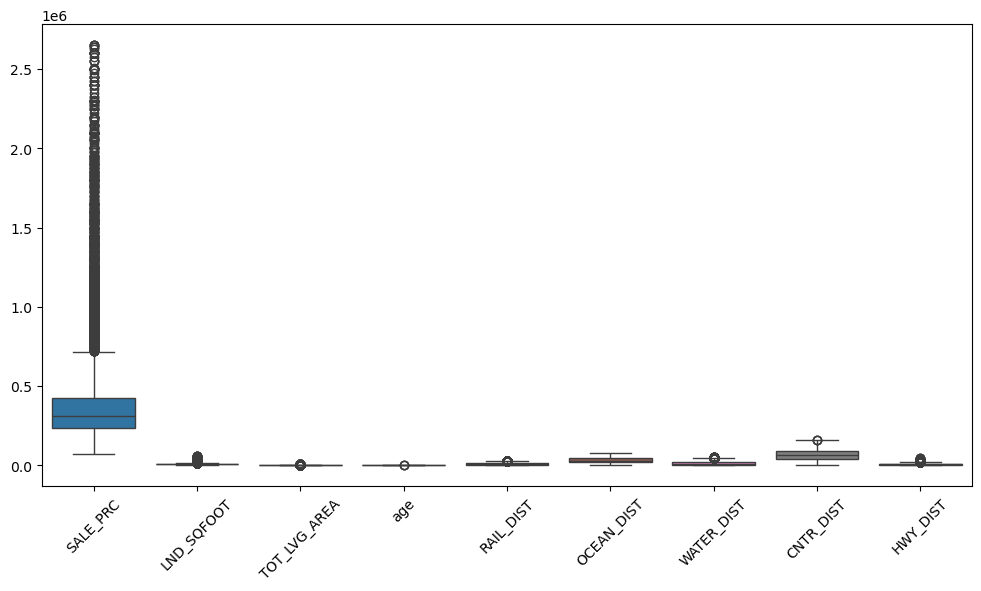

In [700]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols_miami = ['SALE_PRC', 'LND_SQFOOT', 'TOT_LVG_AREA', 'age', 'RAIL_DIST', 'OCEAN_DIST', 'WATER_DIST', 'CNTR_DIST', 'HWY_DIST']

plt.figure(figsize=(12,6))
sns.boxplot(data=df1[numeric_cols_miami])
plt.xticks(rotation=45)
plt.show()

In [701]:
def cap_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower, lower,
                       np.where(df[col] > upper, upper, df[col]))
    return df
# Cap outliers for key columns
for col in ['SALE_PRC', 'LND_SQFOOT', 'TOT_LVG_AREA', 'age']:
    df1= cap_outliers(df1, col)

In [702]:
df1['price_per_sqft'] = df1['SALE_PRC'] / (df1['LND_SQFOOT'] + 1)

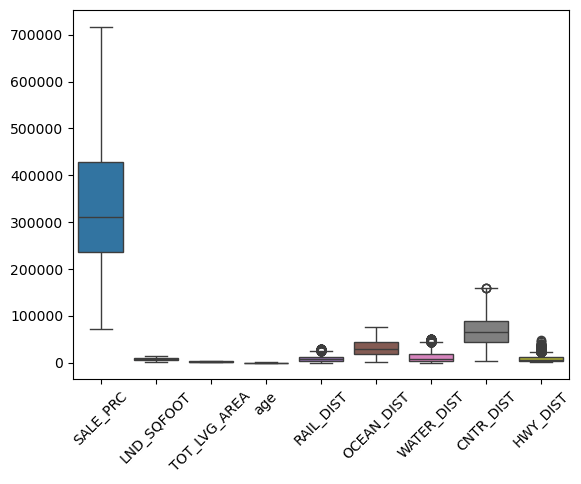

In [703]:
#show after cAPPING
sns.boxplot(data=df1[numeric_cols_miami])
plt.xticks(rotation=45)
plt.show()

<Axes: >

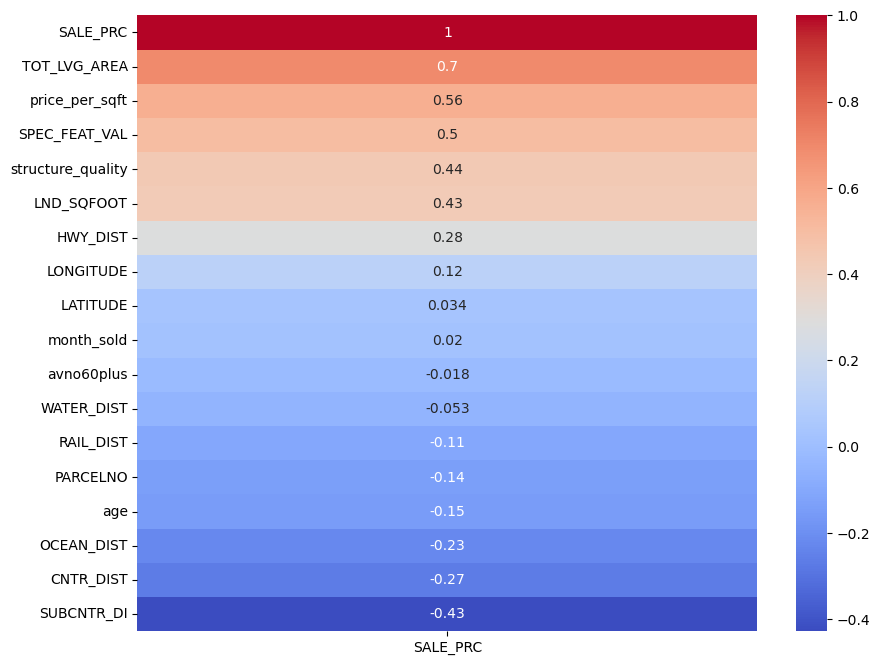

In [704]:
corr = df1.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr[['SALE_PRC']].sort_values(by='SALE_PRC', ascending=False), annot=True, cmap='coolwarm')


In [705]:
#Declaring features and TARGET
features_miami = [
    'TOT_LVG_AREA',
    'LND_SQFOOT',
    'price_per_sqft',
    'SPEC_FEAT_VAL',
    'structure_quality',
    'OCEAN_DIST',
    'CNTR_DIST',
    'SUBCNTR_DI',
    'RAIL_DIST',
    'age'
]
x = df1[features_miami]
y = df1['SALE_PRC']

In [706]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=42)

In [707]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
# Linear Regression
lin_model = LinearRegression()
lin_model.fit(x_train, y_train)

LinearRegression()

In [708]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
# Ensure y is 1D
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [709]:
# Train models
lin_model = LinearRegression().fit(x_train, y_train)
ridge_model = Ridge(alpha=1.0).fit(x_train, y_train)
lasso_model = Lasso(alpha=0.1).fit(x_train, y_train)

In [710]:
# Predictions
y_pred_lin = lin_model.predict(x_test)
y_pred_ridge = ridge_model.predict(x_test)
y_pred_lasso = lasso_model.predict(x_test)

In [711]:
# LINEAR REGRESSION EQUATION 
intercept = lin_model.intercept_
coefficients = lin_model.coef_
print("\nLinear Regression Equation (Miami):")
equation = f"SALE_PRC = {intercept:.2f} "
for feature, coef in zip(x_train.columns, coefficients):
    equation += f"+ ({coef:.2f} * {feature}) "
print(equation)


Linear Regression Equation (Miami):
SALE_PRC = -136236.59 + (51.80 * TOT_LVG_AREA) + (28.22 * LND_SQFOOT) + (4096.55 * price_per_sqft) + (0.73 * SPEC_FEAT_VAL) + (12860.36 * structure_quality) + (-0.93 * OCEAN_DIST) + (-0.48 * CNTR_DIST) + (-0.71 * SUBCNTR_DI) + (1.29 * RAIL_DIST) + (-344.58 * age) 


In [712]:
# MODEL PERFORMANCE
def evaluate(y_true, y_pred, name):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name} -> R²: {r2:.4f}, RMSE: {rmse:.2f}")
evaluate(y_test, y_pred_lin, "Linear Regression")
evaluate(y_test, y_pred_ridge, "Ridge Regression")
evaluate(y_test, y_pred_lasso, "Lasso Regression")

Linear Regression -> R²: 0.8952, RMSE: 55402.30
Ridge Regression -> R²: 0.8952, RMSE: 55402.27
Lasso Regression -> R²: 0.8952, RMSE: 55402.29


LOAD MUMBAI DATASET

In [713]:
df2= pd.read_csv('Mumbai House Prices.csv')
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76038 entries, 0 to 76037
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   bhk         76038 non-null  int64  
 1   type        76038 non-null  object 
 2   locality    76038 non-null  object 
 3   area        76038 non-null  int64  
 4   price       76038 non-null  float64
 5   price_unit  76038 non-null  object 
 6   region      76038 non-null  object 
 7   status      76038 non-null  object 
 8   age         76038 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 5.2+ MB


In [714]:
df2.isna().sum()

bhk           0
type          0
locality      0
area          0
price         0
price_unit    0
region        0
status        0
age           0
dtype: int64

In [715]:
#Drop irrelevant columns  'age' and 'price_unit' columns
df2 = df2.drop(columns=['age', 'price_unit'])
print(df2.head())
print(df2.info())

   bhk       type                              locality  area  price  \
0    3  Apartment   Lak And Hanware The Residency Tower   685   2.50   
1    2  Apartment     Radheya Sai Enclave Building No 2   640  52.51   
2    2  Apartment                         Romell Serene   610   1.73   
3    2  Apartment  Soundlines Codename Urban Rainforest   876  59.98   
4    2  Apartment                         Origin Oriana   659  94.11   

           region              status  
0    Andheri West       Ready to move  
1    Naigaon East  Under Construction  
2   Borivali West  Under Construction  
3          Panvel  Under Construction  
4  Mira Road East  Under Construction  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76038 entries, 0 to 76037
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   bhk       76038 non-null  int64  
 1   type      76038 non-null  object 
 2   locality  76038 non-null  object 
 3   area      76038 non

In [716]:
from sklearn.preprocessing import LabelEncoder
# Make copies of categorical columns
cat_cols = ['type', 'locality', 'region', 'status']
# Apply Label Encoding
encoder = LabelEncoder()
for col in cat_cols:
    df2[col] = encoder.fit_transform(df2[col])

print(df2.head())
print(df2.info())

   bhk  type  locality  area  price  region  status
0    3     0      3019   685   2.50       8       0
1    2     0      4965   640  52.51     124       1
2    2     0      7031   610   1.73      31       1
3    2     0      8484   876  59.98     140       1
4    2     0      4288   659  94.11     117       1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76038 entries, 0 to 76037
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   bhk       76038 non-null  int64  
 1   type      76038 non-null  int64  
 2   locality  76038 non-null  int64  
 3   area      76038 non-null  int64  
 4   price     76038 non-null  float64
 5   region    76038 non-null  int64  
 6   status    76038 non-null  int64  
dtypes: float64(1), int64(6)
memory usage: 4.1 MB
None


In [717]:
# Step 3: Feature Engineering
# 1. Price per square foot
df2['price_per_sqft'] = df2['price'] / df2['area']
# 2. BHK to area ratio (helps identify compact vs spacious homes)
df2['bhk_area_ratio'] = df2['area'] / df2['bhk']
# Preview new columns
print(df2[['price_per_sqft', 'bhk_area_ratio']].head())


   price_per_sqft  bhk_area_ratio
0        0.003650      228.333333
1        0.082047      320.000000
2        0.002836      305.000000
3        0.068470      438.000000
4        0.142807      329.500000


In [718]:
 #Outlier Detection & Capping
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] > upper_bound, upper_bound,
                          np.where(df[column] < lower_bound, lower_bound, df[column]))
    return df
# Apply capping
for col in ['price', 'area', 'price_per_sqft']:
    df2 = cap_outliers(df2, col)
print(df2[['price', 'area', 'price_per_sqft']].describe())

             price          area  price_per_sqft
count  76038.00000  76038.000000    76038.000000
mean      29.38227    966.468312        0.043518
std       32.90345    442.795949        0.052910
min        1.00000    127.000000        0.000214
25%        1.75000    640.000000        0.001745
50%        5.50000    872.000000        0.003417
75%       59.00000   1179.000000        0.081877
max       99.99000   1987.500000        0.202076


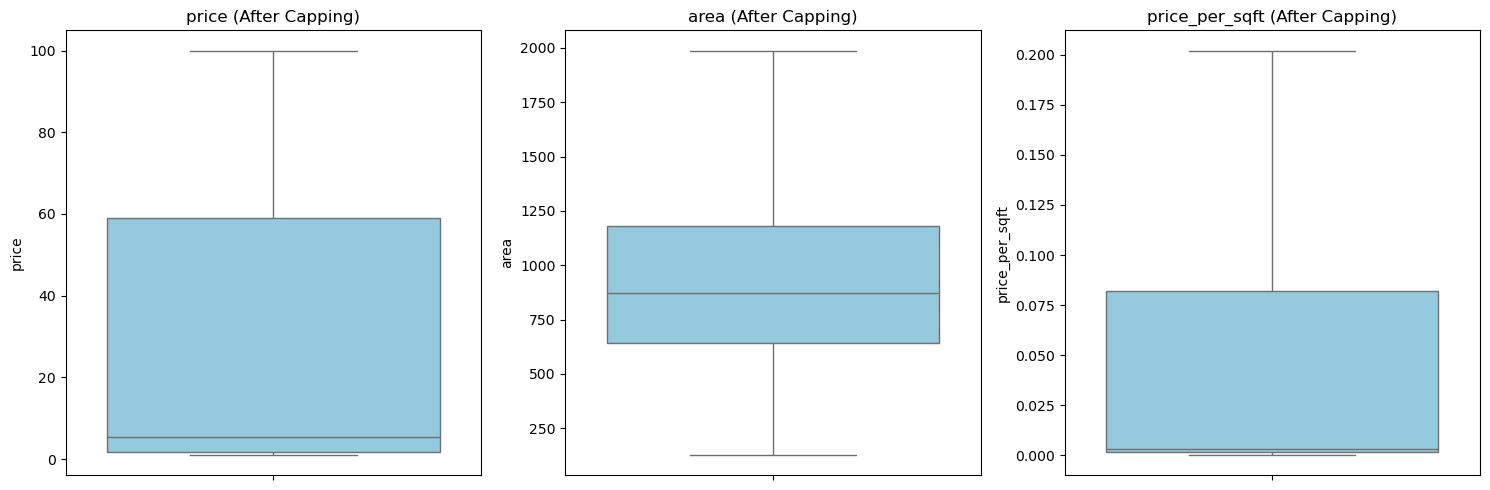

In [719]:
# Visualize the 3 columns after capping
features_to_plot = ['price', 'area', 'price_per_sqft']
plt.figure(figsize=(15, 5))
for i, col in enumerate(features_to_plot, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df2[col], color='skyblue')
    plt.title(f'{col} (After Capping)', fontsize=12)
plt.tight_layout()
plt.show()

                   price       bhk      area  price_per_sqft  bhk_area_ratio
price           1.000000 -0.425078 -0.394730        0.900042        0.047233
bhk            -0.425078  1.000000  0.840947       -0.537501       -0.065631
area           -0.394730  0.840947  1.000000       -0.551989        0.351390
price_per_sqft  0.900042 -0.537501 -0.551989        1.000000       -0.069342
bhk_area_ratio  0.047233 -0.065631  0.351390       -0.069342        1.000000


Text(0.5, 1.0, 'Correlation Heatmap (Mumbai Dataset)')

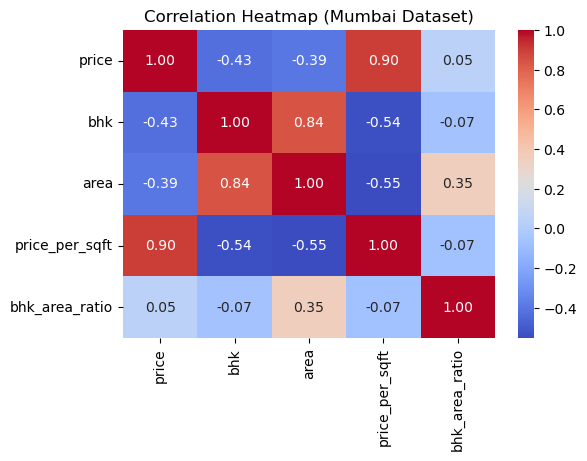

In [720]:
import matplotlib.pyplot as plt
import seaborn as sns
#Correlation matrix
corr_matrix = df2[['price', 'bhk', 'area', 'price_per_sqft', 'bhk_area_ratio']].corr()
print(corr_matrix)
# 2. Heatmap for visual correlation
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap (Mumbai Dataset)")

In [721]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pandas as pd

In [722]:
# Drop rows with NaNs in X or y
x = x.dropna()
y = y.loc[x.index]

In [723]:
print(df2.columns)
features = [col for col in df2.columns if col != 'price']  # This selects all columns except 'price'

# Make sure 'price' exists before using it
if 'price' in df2.columns:
    x = df2[features].fillna(df2[features].mean())
    y = df2['price']
else:
    print("Error: 'price' column not found in the DataFrame")
    # You might want to specify the correct target column name here
    # y = df2['actual_price_column_name']

Index(['bhk', 'type', 'locality', 'area', 'price', 'region', 'status',
       'price_per_sqft', 'bhk_area_ratio'],
      dtype='object')


In [724]:
#Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [725]:
# Train Models
lin_model = LinearRegression()
lin_model.fit(x_train, y_train)

LinearRegression()

In [726]:
y_pred_lin = lin_model.predict(x_test)

In [727]:
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(x_train, y_train)

Lasso(alpha=0.1)

In [728]:
y_pred_lasso = lasso_model.predict(x_test)

In [729]:
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(x_train, y_train)

Ridge()

In [730]:
y_pred_ridge = ridge_model.predict(x_test)

In [731]:
#Evaluation
def evaluate(y_true, y_pred, name):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name} -> R²: {r2:.4f}, RMSE: {rmse:.2f}")
evaluate(y_test, y_pred_lin, "Linear Regression")
evaluate(y_test, y_pred_lasso, "Lasso Regression")
evaluate(y_test, y_pred_ridge, "Ridge Regression")

Linear Regression -> R²: 0.8319, RMSE: 13.52
Lasso Regression -> R²: 0.8274, RMSE: 13.70
Ridge Regression -> R²: 0.8319, RMSE: 13.52


In [732]:
#inear Regression Equation
intercept = lin_model.intercept_
coefficients = lin_model.coef_
print("\nLinear Regression Equation (Mumbai):")
equation = f"price = {intercept:.2f} "
for feature, coef in zip(features, coefficients):
    equation += f"+ ({coef:.2f} * {feature}) "
print(equation)


Linear Regression Equation (Mumbai):
price = -6.40 + (0.02 * bhk) + (605.44 * type) + (-2.68 * locality) 


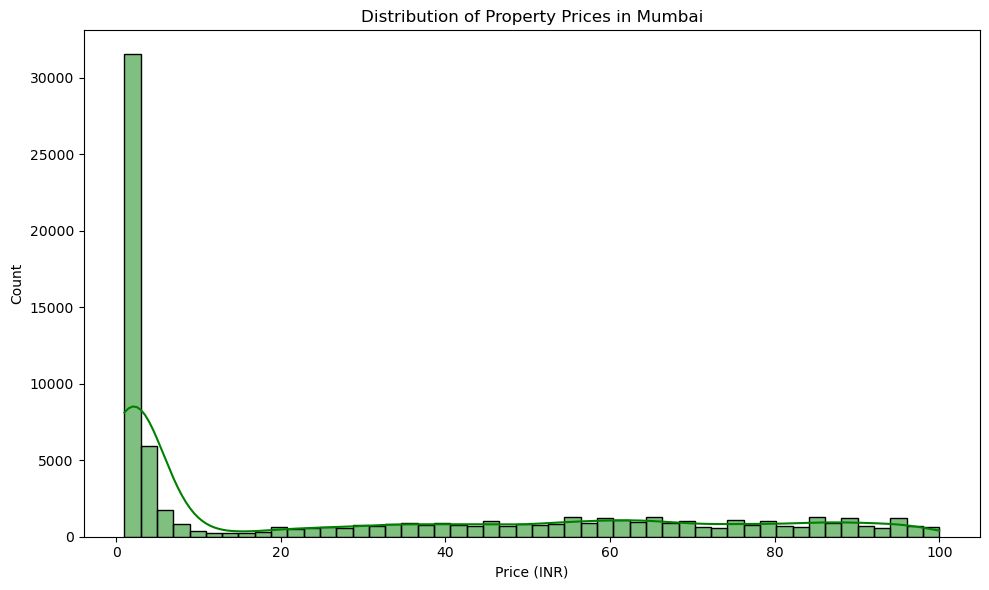

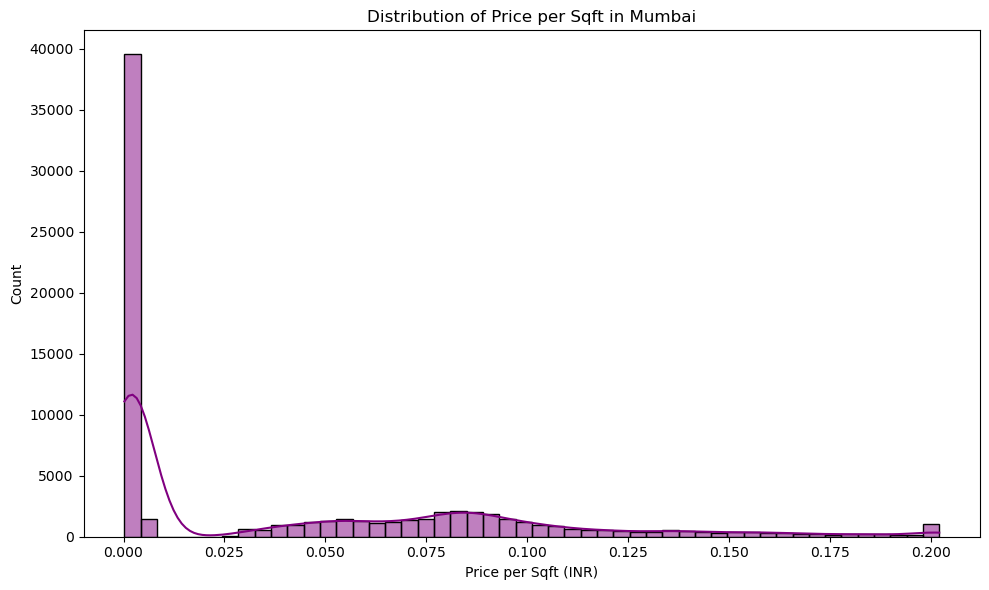

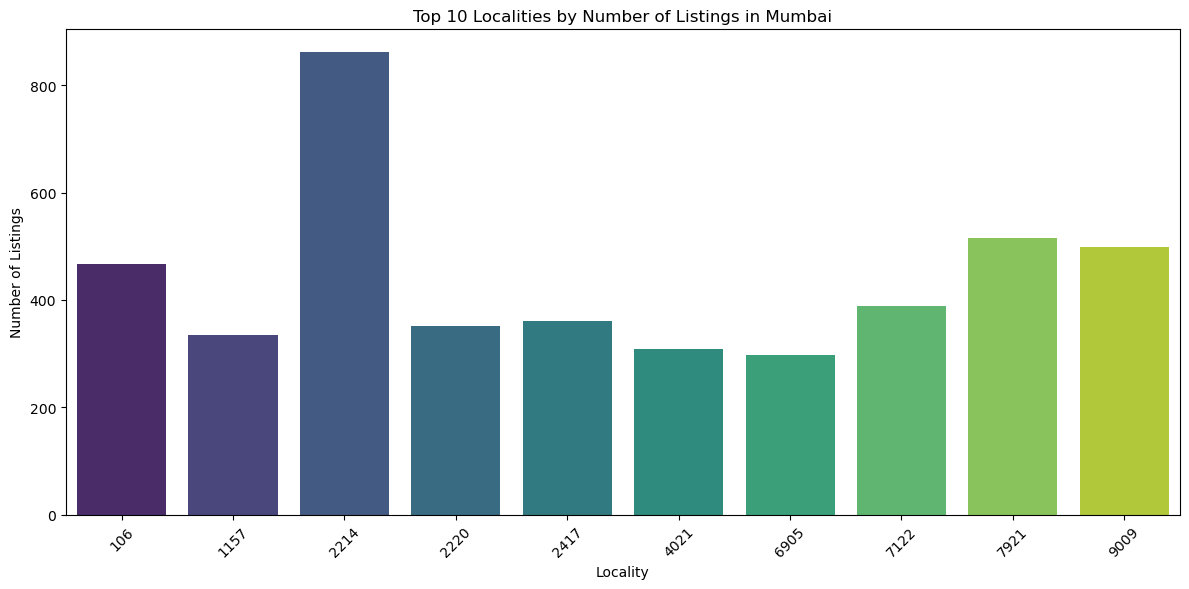

In [747]:
import matplotlib.pyplot as plt
import seaborn as sns

# Clean Mumbai dataset
mumbai_df_clean = df2[(df2['price'] > 0) & 
                            (df2['price_per_sqft'] > 0)]

# Plot 1: Distribution of Property Prices
plt.figure(figsize=(10,6))
sns.histplot(mumbai_df_clean['price'], bins=50, kde=True, color='green')
plt.title("Distribution of Property Prices in Mumbai")
plt.xlabel("Price (INR)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Plot 2: Distribution of Price per Square Foot
plt.figure(figsize=(10,6))
sns.histplot(mumbai_df_clean['price_per_sqft'], bins=50, kde=True, color='purple')
plt.title("Distribution of Price per Sqft in Mumbai")
plt.xlabel("Price per Sqft (INR)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Plot 3: Number of Listings by Locality (Market Size Indicator)
plt.figure(figsize=(12,6))
top_localities = mumbai_df_clean['locality'].value_counts().head(10)
sns.barplot(x=top_localities.index, y=top_localities.values, palette='viridis')
plt.title("Top 10 Localities by Number of Listings in Mumbai")
plt.xlabel("Locality")
plt.ylabel("Number of Listings")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [748]:
#Adding city to each of the locations
df['city'] = 'London'
df1['city'] = 'Miami'
df2['city'] = 'Mumbai'

In [749]:
# Renaming all columns
London_data = df.rename(columns={
    'saleEstimate_currentPrice': 'price',
    'price_per_sqm': 'price_per_sqft',
    'floorAreaSqM': 'area'
})[['price', 'price_per_sqft', 'area', 'city']]

Miami_data = df1.rename(columns={
    'SALE_PRC': 'price',
    'price_per_sqft': 'price_per_sqft',
    'TOT_LVG_AREA': 'area'
})[['price', 'price_per_sqft', 'area', 'city']]

Mumbai_data = df2[['price', 'price_per_sqft', 'area', 'city']]

In [750]:
#Combining all cities
import pandas as pd
all_data = pd.concat([London_data, Miami_data, Mumbai_data], axis=0)
all_data = all_data[(all_data['price'] > 0) & (all_data['price_per_sqft'] > 0)]

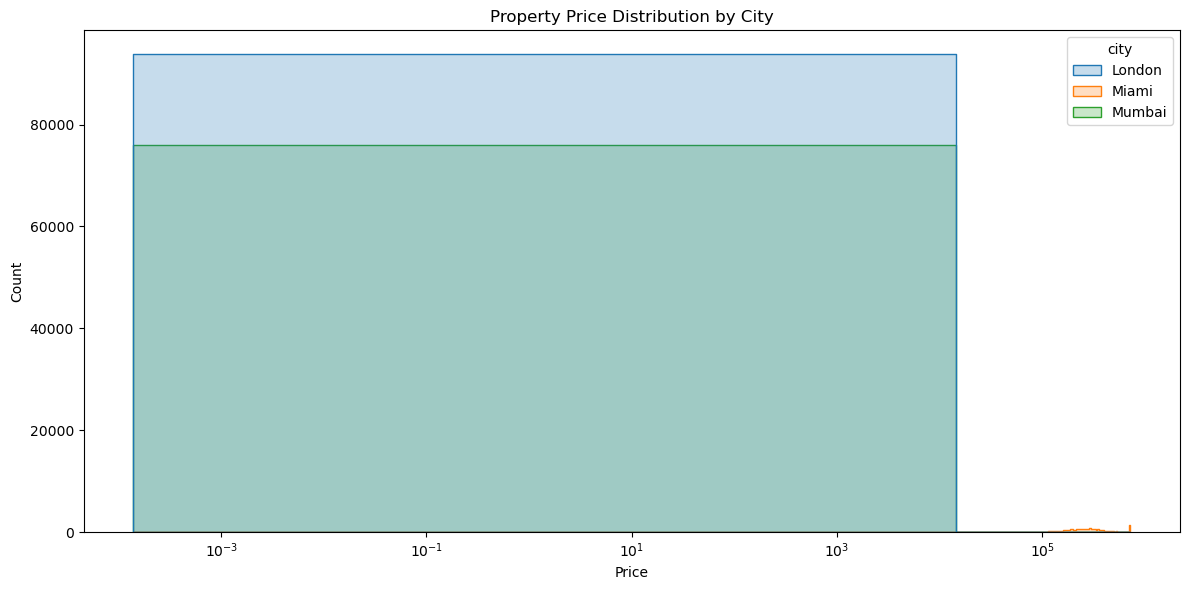

In [751]:
#PRICE DISTRIBUTION COMPARISON FOR ALL LOCATION/CITIES
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.histplot(data=all_data, x='price', hue='city', bins=50, element='step', common_norm=False)
plt.title("Property Price Distribution by City")
plt.xlabel("Price")
plt.ylabel("Count")
plt.xscale('log')  # Log scale for better comparison
plt.tight_layout()
plt.show()

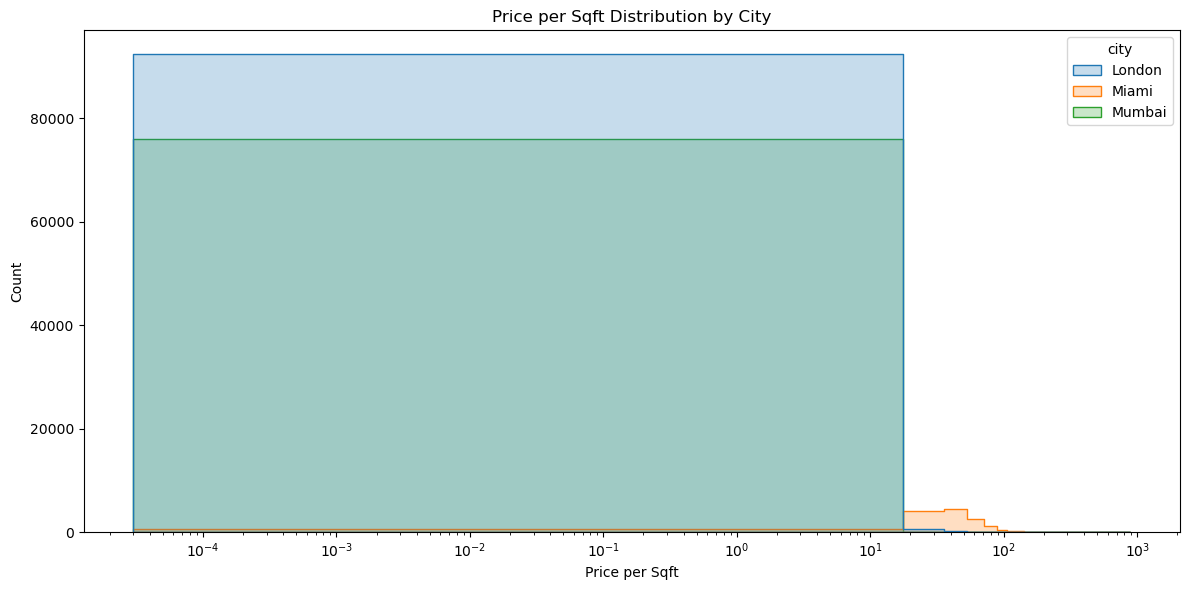

In [752]:
#PRICE PER SQT DISTRIBUTION  COMPARISON FOR ALL LOCATION/CITIES
plt.figure(figsize=(12, 6))
sns.histplot(data=all_data, x='price_per_sqft', hue='city', bins=50, element='step', common_norm=False)
plt.title("Price per Sqft Distribution by City")
plt.xlabel("Price per Sqft")
plt.ylabel("Count")
plt.xscale('log')
plt.tight_layout()
plt.show()

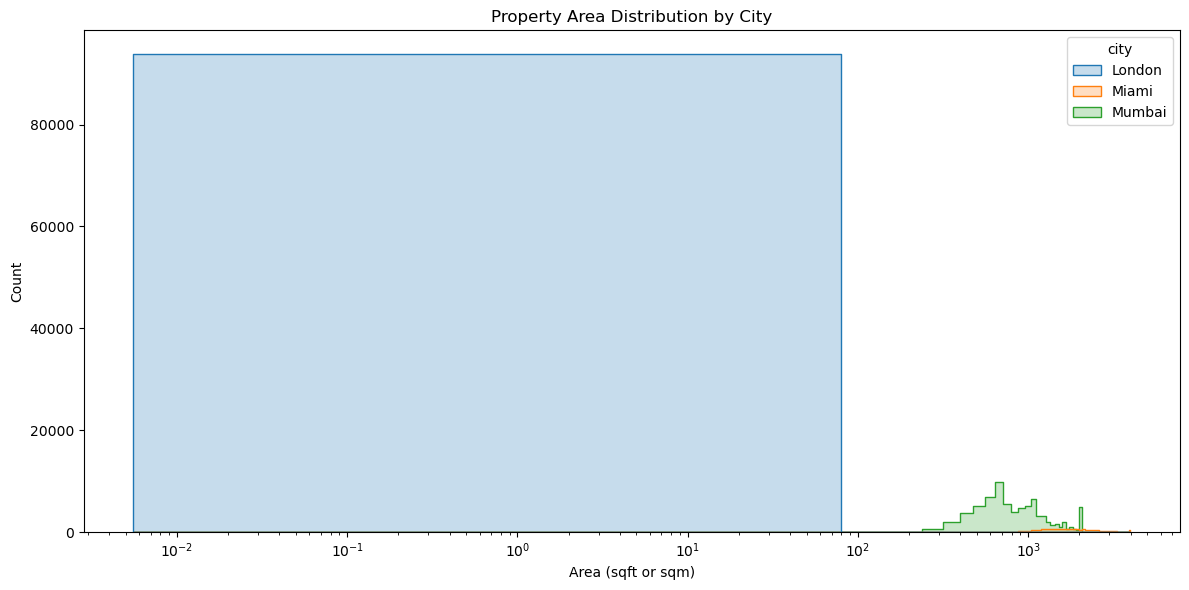

In [753]:
#AREA DISTRIBUTION (PROPERTY SIZE) FOR ALL THREE LOCATIONS/CITIES
plt.figure(figsize=(12, 6))
sns.histplot(data=all_data, x='area', hue='city', bins=50, element='step', common_norm=False)
plt.title("Property Area Distribution by City")
plt.xlabel("Area (sqft or sqm)")
plt.ylabel("Count")
plt.xscale('log')
plt.tight_layout()
plt.show()

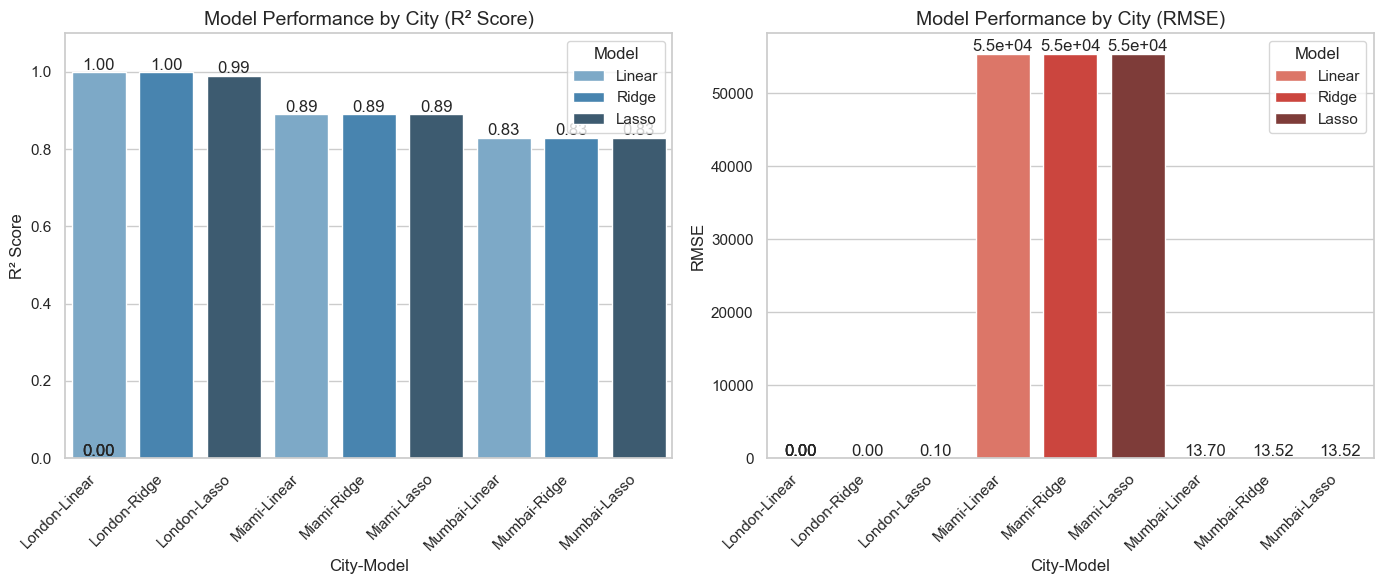

In [766]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Your data (formatted as a DataFrame)
data = {
    "City": ["London", "London", "London", "Miami", "Miami", "Miami", "Mumbai", "Mumbai", "Mumbai"],
    "Model": ["Linear", "Ridge", "Lasso", "Linear", "Ridge", "Lasso", "Linear", "Ridge", "Lasso"],
    "R² Score": [1.0000, 1.0000, 0.9899, 0.89, 0.89, 0.89, 0.83, 0.83, 0.83],
    "RMSE": [0.00, 0.00, 0.10, 55402.30, 55402.29, 55402.27, 13.70, 13.52, 13.52]
}
df = pd.DataFrame(data)

# Create "City-Model" labels for the X-axis
df["City-Model"] = df["City"] + "-" + df["Model"]

# Set style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 6))

# --- Plot 1: R² Scores ---
plt.subplot(1, 2, 1)
ax1 = sns.barplot(data=df, x="City-Model", y="R² Score", hue="Model", palette="Blues_d")
plt.title("Model Performance by City (R² Score)", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1.1)  # Adjust scale for visibility

# Annotate bars with values
for p in ax1.patches:
    ax1.annotate(f"{p.get_height():.2f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# --- Plot 2: RMSE ---
plt.subplot(1, 2, 2)
ax2 = sns.barplot(data=df, x="City-Model", y="RMSE", hue="Model", palette="Reds_d")
plt.title("Model Performance by City (RMSE)", fontsize=14)
plt.xticks(rotation=45, ha="right")

# Annotate bars with values (use scientific notation for Miami's large RMSE)
for p in ax2.patches:
    value = p.get_height()
    ax2.annotate(f"{value:.1e}" if value > 100 else f"{value:.2f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()